<a href="https://colab.research.google.com/github/kazuki-de/git_reserch_code/blob/master/Autoencoder_tensorflow2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation , Softmax, MaxPool2D,UpSampling2D
from tensorflow.keras import Model
import datetime
#import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
#x = tf.Constant(1,shape=(),dtype=tf.int32)
tf.executing_eagerly()

True

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [5]:
cd  /content/drive/My Drive/logs

/content/drive/My Drive/logs


In [0]:
dataset = tf.data.TextLineDataset("/content/drive/My Drive/2048_tissue_choice/sumpling_20csv")

In [7]:
dataset

<TextLineDatasetV2 shapes: (), types: tf.string>

In [0]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/drive/My Drive/logs/gradient_tape", histogram_freq=1)

In [0]:
path = "/content/drive/My Drive/2048pix_tissue_choice/sumpling_20.csv"

In [0]:
class MyModel1(Model):
    def __init__(self):
        super(MyModel1, self).__init__()
        self.Conv1 = Conv2D(2,(7,7),padding="same", activation='relu')
        self.Maxpool1 = MaxPool2D((2, 2), padding='same')
        self.Conv2 = Conv2D(4,(5,5), padding="same",activation='relu')
        self.Maxpool2 = MaxPool2D((2, 2), padding='same')
        self.Conv3 = Conv2D(4,(3,3),padding="same", activation='relu')
        self.Maxpool3 = MaxPool2D((2, 2), padding='same')
        
        self.Conv4 = Conv2D(4,(3,3),padding="same", activation='relu')
        self.Upsumpl1 = UpSampling2D((2, 2))
        self.Conv5 = Conv2D(4,(5,5), padding='same',activation='relu')
        self.Upsumpl2 = UpSampling2D((2, 2))
        self.Conv6 = Conv2D(4,(7,7), padding='same',activation='relu')
        self.Upsumpl3 = UpSampling2D((2, 2))
        self.Conv7 = Conv2D(3,(3,3), padding='same',activation='relu')
    
    def call(self, x):
        x = self.Conv1(x)
        x = self.Maxpool1(x)
        x = self.Conv2(x)
        x = self.Maxpool2(x)
        x = self.Conv3(x)
        x = self.Maxpool3(x)
        x = self.Conv4(x)
        x = self.Upsumpl1(x)
        x = self.Conv5(x)
        x = self.Upsumpl2(x)
        x = self.Conv6(x)
        x = self.Upsumpl3(x)
        return self.Conv7(x)

model1 = MyModel1()

In [0]:
#損失関数
loss_object = tf.keras.losses.MeanSquaredError()
#最適化手法
optimizer = tf.keras.optimizers.Adam()

#評価関数
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [0]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        predictions = model1(image)
        #softmax = Activation('softmax')(predictions)
        loss = loss_object(image, predictions)
        #VAT_loss = VAT_KL(image,model2)
        #print(loss.numpy())
        #print(loss.shape)
        #loss_add = loss + VAT_loss
    gradients = tape.gradient(loss, model1.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model1.trainable_variables))

    train_loss(loss)
    #train_accuracy(label, )


@tf.function
def test_step(image):
    predictions = model1(image)
    #softmax = Activation('softmax')(predictions)
    t_loss = loss_object(image, predictions)

    test_loss(t_loss)
    #test_accuracy(label, softmax)


In [0]:
path = "/content/drive/My Drive/2048pix_tissue_choice/sumpling_20.csv"
def generater_train():
    file_path1 = pd.read_csv("/content/drive/My Drive/2048pix_tissue_choice/tran_6000.csv")
    file_path1 = file_path1[0:300]
    
    # LabelEncode(classをint型に変換)するためのdict\n",
    classes =["PI","PP","TRU"]
    classes = {v: i for i, v in enumerate(sorted(classes))}
    #file_path1 = pd.read_csv(file_path)
    length = len(file_path1)
    for i in range(length):
        path = file_path1.loc[i]["path1"]
        with Image.open(path) as f:
                tmp_image = np.asarray(f, dtype=np.float32)/255
        label = file_path1.loc[i]["type"]
        tmp_label = tf.keras.utils.to_categorical(classes[label],len(classes))
        #print(tmp_labels, np.mean(tmp_images, axis=(1,2,3)))
        yield tmp_image, tmp_label


In [0]:
def generater_val():
    file_path1 = pd.read_csv("/content/drive/My Drive/2048pix_tissue_choice/val_1000.csv")
    file_path1 =file_path1[0:300]
    
    # LabelEncode(classをint型に変換)するためのdict\n",
    classes =["PI","PP","TRU"]
    classes = {v: i for i, v in enumerate(sorted(classes))}
    #file_path1 = pd.read_csv(file_path)
    length = len(file_path1)
    for i in range(length):
        path = file_path1.loc[i]["path1"]
        with Image.open(path) as f:
                tmp_image = np.asarray(f, dtype=np.float32)/255
        label = file_path1.loc[i]["type"]
        tmp_label = tf.keras.utils.to_categorical(classes[label],len(classes))
        #print(tmp_labels, np.mean(tmp_images, axis=(1,2,3)))
        yield tmp_image, tmp_label


In [15]:
#@title デフォルトのタイトル テキスト
EPOCHS = 1
#model = MyModel()
batchsize = 10
dataset_t = tf.data.Dataset.from_generator(generater_train, output_types=(tf.float32, tf.int32)).batch(10)
dataset_v = tf.data.Dataset.from_generator(generater_val, output_types=(tf.float32, tf.int32)).batch(10)

for epoch in range(EPOCHS):
    for batch, (x_t,x_l) in enumerate(dataset_t):
        train_step(x_t)
        if batch%100 ==0:
            print(batch)
    #with train_summary_writer.as_default():
        #tf.summary.scalar('loss', train_loss.result(), step=epoch)
        #tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    
    
    for batch, (y_t,y_l) in enumerate(dataset_t):
        test_step(y_t)
    #with test_summary_writer.as_default():
        #tf.summary.scalar('loss', test_loss.result(), step=epoch)
        #tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         #train_accuracy.result()*100,
                         test_loss.result()
                         #test_accuracy.result()*100)
                          ))
    
#train_loss.reset_states()
#test_loss.reset_states()
#train_accuracy.reset_states()
#test_accuracy.reset_states()

W0827 07:42:10.585539 140664941590400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


0
Epoch 1, Loss: 0.2145138531923294, Test Loss: 0.05083296075463295


In [0]:
model1.save_weights('/content/drive/My Drive/research_/weight_autoencoder_2048_0827/my_model_weights.h5')

In [17]:
model.load_weights('/content/drive/My Drive/research_/weight_autoencoder_2048_0827/my_model_weights.h5')

NameError: ignored

In [0]:
import matplotlib.pyplot as plt
import random


In [0]:
file_path1 = pd.read_csv("/content/drive/My Drive/2048pix_tissue_choice/val_1000.csv")
file_path1 =file_path1[400:410]

tmp_images = np.zeros((len(file_path1), 2048, 2048, 3))
count = 400
for i in range(10):
    path = file_path1.loc[count]["path1"]
    count+=1
    with Image.open(path) as f:
        tmp_images[i] = np.asarray(f, dtype=np.float32)/255


In [0]:
tem = tmp_images.astype(np.float32)

In [0]:
y = model1(tem)

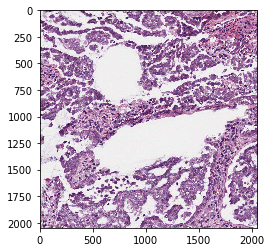

In [24]:
plt.imshow(tem[2])


W0827 07:44:35.437578 140664941590400 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: ignored

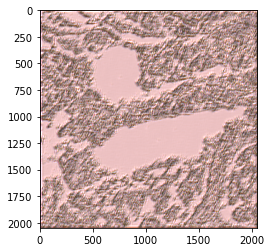

In [23]:
plt.imshow(y[2])
x.shape

In [0]:
y